# U-Net for Snow Segmentation in Aerial Images

### Data Preparation

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread


In [5]:
#gpu stuff
print(tf.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Define U-Net Model

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Cropping2D
from tensorflow.keras.models import Model

def unet(input_size=(800, 640, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    # c4 = Cropping2D(((1, 0), (0, 0)))(c4)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    # c3 = Cropping2D(((0, 3), (0, 0)))(c3)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    # c2 = Cropping2D(((1, 5), (0, 0)))(c2)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()
    

### Data Augmentation and Training

In [11]:
#get image and mask paths
#convert to dataframe
import pandas as pd
import os
df = pd.read_csv('data/640x800/640x800.csv')

image_paths = np.array(df['snow_path'].values)
mask_paths = np.array(df['snowbinary_path'].values)
image_paths.shape


(131,)

In [12]:

def load_data(image_paths, mask_paths):
    images = [imread(img_path) for img_path in image_paths]
    masks = [imread(mask_path) for mask_path in mask_paths]
    
    #resize all images with 4 channels to 3 channels
    for i in range(len(images)):
        if(len(images[i][0][0])==4):
            images[i] = images[i][:,:,:3]

    #resize all masks to 1120x640
    for i in range(len(masks)):
        masks[i] = masks[i][:1120,:640]
    
    
    return np.array(images), np.array(masks)

images, masks = load_data(image_paths, mask_paths)

In [13]:
masks = masks[..., np.newaxis]
masks.shape


(131, 800, 640, 1)

In [18]:
# Assuming your images and masks are numpy arrays
# masks = masks[..., np.newaxis]  # add a channel dimension if necessary

images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_dataset = tf.data.Dataset.from_tensor_slices(masks)

def augment_data(image, mask):
    # Random rotation
    rotation_angle = tf.random.uniform(shape=[], minval=-10, maxval=10, dtype=tf.float32)
    image = tf.image.rot90(image, tf.cast(rotation_angle / 90, tf.int32))
    mask = tf.image.rot90(mask, tf.cast(rotation_angle / 90, tf.int32))

    # Random horizontal flip
    if tf.random.uniform(shape=[], dtype=tf.float32) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    return image, mask

augmented_dataset = tf.data.Dataset.zip((images_dataset, masks_dataset))
augmented_dataset = augmented_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

augmented_dataset = augmented_dataset.shuffle(1000)

BATCH_SIZE = 10
augmented_dataset = augmented_dataset.batch(BATCH_SIZE)
augmented_dataset = augmented_dataset.prefetch(tf.data.AUTOTUNE)

In [16]:
# Define the ModelCheckpoint callback to save weights at each epoch
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/unet_640x1132_epoch_{epoch:02d}.keras',
    save_weights_only=False,
    save_best_only=False,
    save_freq='epoch'
)
os.makedirs('checkpoints', exist_ok=True)


In [19]:
#fit the model
model.fit(augmented_dataset, epochs=50, callbacks=[checkpoint_callback], verbose=1)

Epoch 1/50


2024-06-18 09:49:16.824037: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-18 09:49:16.834138: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.57 = (f32[10,64,800,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,3,800,640]{3,2,1,0} %transpose.366, f32[64,3,3,3]{3,2,1,0} %transpose.367, f32[64]{0} %arg3.4), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_53_1/convolution" source_file="/home/apfox/anaconda3/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_co

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/apfox/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/apfox/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/apfox/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_130049/2649965364.py", line 2, in <module>

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 314, in fit

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv-bias-activation.57 = (f32[10,64,800,640]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,3,800,640]{3,2,1,0} %transpose.366, f32[64,3,3,3]{3,2,1,0} %transpose.367, f32[64]{0} %arg3.4), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="functional_1_1/conv2d_53_1/convolution" source_file="/home/apfox/anaconda3/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1327497216 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_9523]

In [ ]:
#save the model

model.save('unet_640x1132.keras')

In [21]:
#open the saved model
model = tf.keras.models.load_model('unet_640x1132.keras')

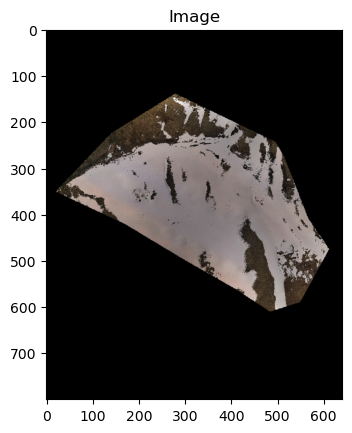

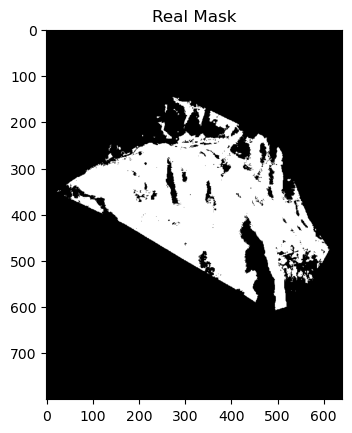

2024-06-18 11:20:00.112305: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 719.42MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-18 11:20:07.605675: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 484.75MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-18 11:20:07.618320: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at xla_ops.cc:580 : UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.72 = (f32[10,96,320,400]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,16,320,400]{3,2,1,0} %add.236, f32[96,16,1,1]{3,2,1,0} %transpose.122), window={size=1x1}, dim_labels=bf01_oi01->bf01

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/apfox/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/home/apfox/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/home/apfox/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_130049/2671363071.py", line 20, in <module>

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 504, in predict

  File "/home/apfox/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 204, in one_step_on_data_distributed

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.72 = (f32[10,96,320,400]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,16,320,400]{3,2,1,0} %add.236, f32[96,16,1,1]{3,2,1,0} %transpose.122), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", metadata={op_type="Conv2D" op_name="functional_1_1/block_1_expand_1/convolution" source_file="/home/apfox/anaconda3/lib/python3.11/site-packages/tensorflow/python/framework/ops.py" source_line=1177}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}}

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 508297216 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_16234]

In [29]:
#visualize a prediction
import matplotlib.pyplot as plt
# Visualize an image
plt.imshow(images[0])
plt.title('Image')
plt.show()

# Visualize the real mask
plt.imshow(masks[0], cmap='gray')
plt.title('Real Mask')
plt.show()

# Visualize the predicted mask
# Extract a batch of images from the dataset
batch_images = next(iter(images_dataset.batch(BATCH_SIZE)))

batch_images = tf.transpose(batch_images, perm=[0, 2, 1, 3])

# Predict masks using the model
predicted_masks = model.predict(batch_images)

# Visualize the prediction (for the first image in the batch)
plt.imshow(predicted_masks[0], cmap='gray')  # Assuming grayscale output
plt.title('Predicted Mask')
plt.show()

In [ ]:
import rasterio

# Define the output file path
output_file = "predicted_mask.tif"

# Write the predicted mask to the TIFF file
with rasterio.open(output_file, 'w', driver='GTiff', height=predicted_masks[0].shape[0], width=predicted_masks[0].shape[1], count=1, dtype=predicted_masks[0].dtype) as dst:
    dst.write(predicted_masks[0], 1)